In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from eye_functions import *
import plotly_express as px
from sklearn.model_selection import train_test_split
from skimage.measure import block_reduce 
from skimage.io import imread

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

In [104]:
eyes = pd.read_csv('full_df.csv')
eyes = eyes[(eyes['labels']=="['N']") | (eyes['labels']=="['C']")]
eyes['eyes_emoji']=0
eyes.loc[eyes['labels'] == "['C']", 'eyes_emoji'] = 1


In [105]:
Y = eyes['eyes_emoji']
X = eyes['filename']

In [106]:
plotter = pd.DataFrame({'Cataracts' : Y.values.astype(str) , 'eyes' : X.str.contains('right')*1})
plotter.eyes.replace([1,0],['Right','Left'],inplace=True)
px.histogram(plotter, x='Cataracts',color='eyes',text_auto=True)

In [63]:
def image_matrix(sets):
    matrices = []
    for link in sets:
        image = Image.open('preprocessed_images/%s' % link)
        if image.mode != "RGB":
            image = image.convert("RGB")
        orig_array = np.asarray(image)
        resized = block_reduce(orig_array, (2, 2, 1), np.max)
        normed_array = resized / 255
        matrices.append(normed_array)

    stacked_arrays = np.stack(matrices, axis=0)
    return stacked_arrays


#

In [77]:
#selecing only the right eye. I had hoped that perhaps the orientation of the blood vessel of the left and right eye causes the low accuracy in the CV set, but meh accuracy still sucks.
# right_x = diabetes[diabetes['eyes_side'] ==1].filename
# right_y = diabetes[diabetes['eyes_side'] ==1].eyes_emoji
X1, x_test, Y1, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8,random_state=1,stratify= Y)

In [83]:
image_train = image_matrix(X1)

In [84]:
image_test =  image_matrix(x_test)

In [66]:
print("train X shape: ", X1.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", Y1.shape) # y_train: numpy array with shape: (num_samples_train,) 
#print("test X shape: ", x_test.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
#print("test y shape: ", y_test.shape)   # y_test: numpy array with shape: (num_samples_test,)
print("image_train.shape: ", image_train.shape)

train X shape:  (2532,)
train y shape:  (2532,)
image_train.shape:  (2532, 256, 256, 3)


a. Create a TF checkpoint. Run your previous NN model and save the best weights after training.

In [ ]:
model1 = Sequential([
    Flatten(input_shape=(image_train.shape[1:])), BatchNormalization(),
    Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)), BatchNormalization(momentum = 0.8 , epsilon= 0.003),
    Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)), BatchNormalization(momentum = 0.8 , epsilon= 0.003),
    Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)), BatchNormalization(momentum = 0.8 , epsilon= 0.003),
    Dense(1, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(0.001)), BatchNormalization(momentum = 0.8 , epsilon= 0.003)
])

In [ ]:
model1.summary()

In [ ]:
model1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy',tf.keras.metrics.Recall()])


In [ ]:
checkpoint_filepath = '\checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

In [ ]:
history1 = model1.fit(image_train, Y1, epochs = 30, batch_size = 64, verbose = 2, validation_split=0.2)

In [ ]:
print(history1.history.keys())

In [ ]:
plt.plot(history1.history['binary_accuracy'])
plt.plot(history1.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Make a plot for the recall

plt.plot(list(history1.history.values())[2])
plt.plot(list(history1.history.values())[5])
plt.title('recall vs. epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# CNN

In [67]:
Y1 = Y1.values.reshape((-1,1))

In [68]:
model = Sequential([
            Conv2D(filters = 5, kernel_size = (4,4), activation = 'relu', input_shape = image_train.shape[1:]), #1
            MaxPooling2D(pool_size=2, strides=(2,2)), #2
            Conv2D(filters = 6, kernel_size = (4,4), activation = 'relu'), #3
            MaxPooling2D(pool_size=2, strides=(2,2)), #4
            Flatten(), #5
            Dense(120, activation='relu'), 
            BatchNormalization(),  # <- Batch normalization layer 1
            Dropout(0.2),
            Dense(84, activation='relu'), 
            BatchNormalization(),  # <- Batch normalization layer 1
            Dropout(0.2), #dropout rate 
            Dense(1, activation = 'sigmoid') #output
])

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 253, 253, 5)       245       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 5)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 123, 123, 6)       486       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 6)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 22326)             0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [70]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy',tf.keras.metrics.Recall()])

In [71]:
checkpoint_filepath = '~/checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)

In [72]:
history = model.fit(image_train, Y1, epochs = 10, batch_size = 64, verbose = 2, validation_split = 0.20, callbacks = [model_checkpoint_callback])

Epoch 1/100
32/32 - 11s - loss: 0.7335 - binary_accuracy: 0.6346 - recall_2: 0.4513 - val_loss: 0.5793 - val_binary_accuracy: 0.7751 - val_recall_2: 0.3077 - 11s/epoch - 357ms/step
Epoch 2/100
32/32 - 10s - loss: 0.6048 - binary_accuracy: 0.7225 - recall_2: 0.4308 - val_loss: 0.4448 - val_binary_accuracy: 0.9112 - val_recall_2: 0.1538 - 10s/epoch - 312ms/step
Epoch 3/100
32/32 - 10s - loss: 0.5301 - binary_accuracy: 0.7714 - recall_2: 0.3077 - val_loss: 0.4008 - val_binary_accuracy: 0.9250 - val_recall_2: 0.0769 - 10s/epoch - 312ms/step
Epoch 4/100
32/32 - 10s - loss: 0.4862 - binary_accuracy: 0.8030 - recall_2: 0.2615 - val_loss: 0.3000 - val_binary_accuracy: 0.9231 - val_recall_2: 0.0513 - 10s/epoch - 303ms/step
Epoch 5/100
32/32 - 10s - loss: 0.4283 - binary_accuracy: 0.8420 - recall_2: 0.2410 - val_loss: 0.2806 - val_binary_accuracy: 0.9250 - val_recall_2: 0.0513 - 10s/epoch - 309ms/step
Epoch 6/100
32/32 - 10s - loss: 0.3931 - binary_accuracy: 0.8622 - recall_2: 0.2410 - val_loss:

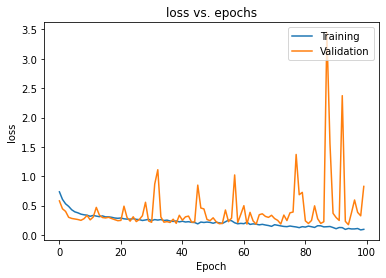

In [73]:

plt.plot(list(history.history.values())[0])
plt.plot(list(history.history.values())[3])
plt.title('loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

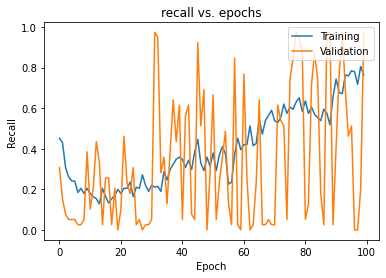

In [74]:

plt.plot(list(history.history.values())[2])
plt.plot(list(history.history.values())[5])
plt.title('recall vs. epochs')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

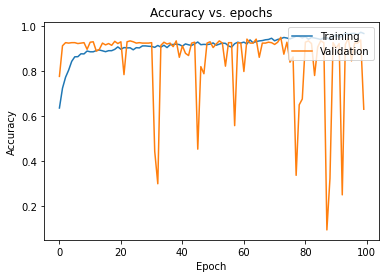

In [75]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

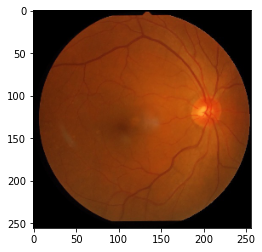

Label: 0


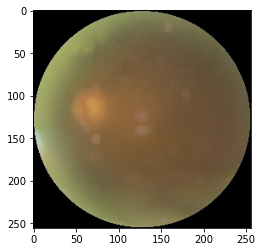

Label: 1


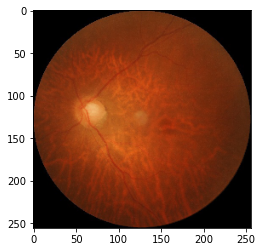

Label: 0


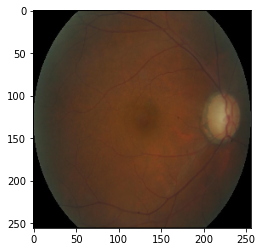

Label: 0


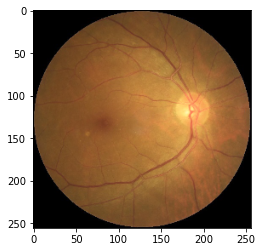

Label: 0


In [109]:
random_inx = np.random.choice(x_test.shape[0],5)
X_sample = image_test[random_inx]
y_sample = y_test.iloc[random_inx].values
for i,value in enumerate(X_sample):
    plt.imshow(value)
    plt.show()
    print(f"Label: {y_sample[i]}")

In [110]:

predictions = model.predict(X_sample)

1/1 [==============================] - 0s 100ms/step


In [ ]:
predictions1 = model1.predict(X_sample)

In [112]:
for i in range(len(predictions)):    
    print(f"Actual prediction:{y_sample[i]}")
    print(f"CNN Model prediction:{predictions[i]}")
    #print(f"NN Model prediction:{predictions1[i]}")

Actual prediction:0
CNN Model prediction:[0.4907026]
Actual prediction:1
CNN Model prediction:[0.88429433]
Actual prediction:0
CNN Model prediction:[0.12327176]
Actual prediction:0
CNN Model prediction:[0.42663887]
Actual prediction:0
CNN Model prediction:[0.8045062]
